## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [37]:
from keras.layers import BatchNormalization, Activation, Dropout
from keras.regularizers import l2
def build_mlp(input_shape,output_units=10,neurons=[512,256,128],Regu=False,BN=False,Drop=False):
    input_layer = keras.layers.Input(input_shape)
    for i,n in enumerate(neurons):
        if i == 0:
            if Regu==False:
                x = keras.layers.Dense(units=n,
                                       activation='relu',
                                       name='hidden_layer'+str(i+1))(input_layer)
            if Regu:
                x = keras.layers.Dense(units=n, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(1e-12))(input_layer)
            if BN:
                x = BatchNormalization()(x)
            if Drop:
                x = Dropout(0.2)(x)
        else:
            if Regu==False:
                x = keras.layers.Dense(units=n,
                                       activation='relu',
                                       name='hidden_layer'+str(i+1))(x)
            if Regu:
                x = keras.layers.Dense(units=n, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(1e-12))(input_layer)
            if BN:
                x = BatchNormalization()(x)
            if Drop:
                x = Dropout(0.2)(x)
    """Code Here
    建立你的神經網路
    """
    out = keras.layers.Dense(units=output_units,activation='softmax',name='output')(x)
    model = keras.models.Model(inputs=[input_layer],outputs=[out])
    return model

In [35]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 32
Regus = [True, False]
BNs = [True, False]
Drops = [True, False]
MOMENTUM = 0.95
print(list(itertools.product(Regus, BNs, Drops)))

[(True, True, True), (True, True, False), (True, False, True), (True, False, False), (False, True, True), (False, True, False), (False, False, True), (False, False, False)]


In [38]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for Regu,BN,Drop in itertools.product(Regus, BNs, Drops):
    print('Regu = %i,BN = %i,Drop = %i'%(Regu,BN,Drop))
    model=build_mlp(input_shape=x_train.shape[1:],Regu=Regu,BN=BN,Drop=Drop)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE,nesterov=True,momentum=MOMENTUM)
    model.compile(loss='categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer=optimizer)
    model.fit(x_train,y_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              validation_data=(x_test,y_test),
              shuffle=True)
    exp_tag = ('Regu = %i,BN = %i,Drop = %i'%(Regu,BN,Drop))
    
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    results[exp_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
#     results[exp_tag]={'train_loss':model.history,history['loss']
#                       'valid_loss':model.history,history['val_loss']
#                       'train_acc':model.history.history['acc']
#                       'valid_acc':model.history.history['val_acc']
#     }

Regu = 1,BN = 1,Drop = 1
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               393344    
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 395,146
Trainable params: 394,890
Non-trainable params: 256
___________________________________________

Epoch 45/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.6173 - acc: 0.4284 - val_loss: 1.5849 - val_acc: 0.4451
Epoch 46/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.6114 - acc: 0.4308 - val_loss: 1.6033 - val_acc: 0.4367
Epoch 47/50
50000/50000 [==============================] - 6s 110us/step - loss: 1.6210 - acc: 0.4272 - val_loss: 1.5813 - val_acc: 0.4422
Epoch 48/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.6180 - acc: 0.4259 - val_loss: 1.6053 - val_acc: 0.4306
Epoch 49/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.6197 - acc: 0.4281 - val_loss: 1.5828 - val_acc: 0.4402
Epoch 50/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.6132 - acc: 0.4291 - val_loss: 1.5936 - val_acc: 0.4315
Regu = 1,BN = 1,Drop = 0
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Par

50000/50000 [==============================] - 5s 110us/step - loss: 1.3514 - acc: 0.5220 - val_loss: 1.5297 - val_acc: 0.4599
Epoch 48/50
50000/50000 [==============================] - 6s 110us/step - loss: 1.3453 - acc: 0.5238 - val_loss: 1.5086 - val_acc: 0.4688
Epoch 49/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.3476 - acc: 0.5214 - val_loss: 1.4885 - val_acc: 0.4839
Epoch 50/50
50000/50000 [==============================] - 5s 110us/step - loss: 1.3448 - acc: 0.5244 - val_loss: 1.5387 - val_acc: 0.4612
Regu = 1,BN = 0,Drop = 1
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               393344    
_________________________________________________________________
dropout_6 (Dropout

50000/50000 [==============================] - 4s 83us/step - loss: 1.2934 - acc: 0.5402 - val_loss: 1.3896 - val_acc: 0.5139
Epoch 50/50
50000/50000 [==============================] - 4s 84us/step - loss: 1.2892 - acc: 0.5415 - val_loss: 1.3845 - val_acc: 0.5092
Regu = 1,BN = 0,Drop = 0
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               393344    
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.9010 - acc: 0.3305 - val_loss: 1.6987 - val_acc: 0.3944
Epoch 2/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.6960 - acc: 0.3936 - val_loss: 1.5931 - val_acc: 0.4309
Epoch 3/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.6485 - acc: 0.4101 - val_loss: 1.5823 - val_acc: 0.4379
Epoch 4/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.6251 - acc: 0.4191 - val_loss: 1.5330 - val_acc: 0.4577
Epoch 5/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.6110 - acc: 0.4274 - val_loss: 1.5561 - val_acc: 0.4315
Epoch 6/50
50000/50000 [==============================] - 10s 202us/step - loss: 1.5968 - acc: 0.4288 - val_loss: 1.5393 - val_acc: 0.4462
Epoch 7/50
50000/50000 [==============================] - 10s 202us/step - loss: 1.5800 - acc: 0.4346 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 219us/step - loss: 1.7252 - acc: 0.3892 - val_loss: 1.6036 - val_acc: 0.4268
Epoch 2/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.5295 - acc: 0.4562 - val_loss: 1.6057 - val_acc: 0.4320
Epoch 3/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.4566 - acc: 0.4829 - val_loss: 1.4897 - val_acc: 0.4715
Epoch 4/50
50000/50000 [==============================] - 10s 197us/step - loss: 1.4151 - acc: 0.4968 - val_loss: 1.4925 - val_acc: 0.4678
Epoch 5/50
50000/50000 [==============================] - 10s 202us/step - loss: 1.3792 - acc: 0.5090 - val_loss: 1.5351 - val_acc: 0.4636
Epoch 6/50
50000/50000 [==============================] - 10s 201us/step - loss: 1.3409 - acc: 0.5222 - val_loss: 1.4609 - val_acc: 0.4783
Epoch 7/50
50000/50000 [==============================] - 10s 201us/step - loss: 1.3105 - acc: 0.5356 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.9589 - acc: 0.2810 - val_loss: 1.7607 - val_acc: 0.3702
Epoch 2/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.7829 - acc: 0.3578 - val_loss: 1.6758 - val_acc: 0.3969
Epoch 3/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.7179 - acc: 0.3867 - val_loss: 1.6099 - val_acc: 0.4365
Epoch 4/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.6636 - acc: 0.4044 - val_loss: 1.5521 - val_acc: 0.4473
Epoch 5/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.6190 - acc: 0.4231 - val_loss: 1.5240 - val_acc: 0.4516
Epoch 6/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.5907 - acc: 0.4331 - val_loss: 1.5143 - val_acc: 0.4611
Epoch 7/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.5644 - acc: 0.4443 - val_loss: 1.4924 - 

Epoch 2/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.6051 - acc: 0.4275 - val_loss: 1.6179 - val_acc: 0.4232
Epoch 3/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.5238 - acc: 0.4591 - val_loss: 1.5441 - val_acc: 0.4508
Epoch 4/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.4683 - acc: 0.4738 - val_loss: 1.4754 - val_acc: 0.4642
Epoch 5/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.4237 - acc: 0.4933 - val_loss: 1.4596 - val_acc: 0.4695
Epoch 6/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.3827 - acc: 0.5078 - val_loss: 1.4186 - val_acc: 0.4867
Epoch 7/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.3459 - acc: 0.5196 - val_loss: 1.4521 - val_acc: 0.4765
Epoch 8/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.3135 - acc: 0.5334 - val_loss: 1.3884 - val_acc: 0.5059
Epoch 9/50
50000/50000 [==========

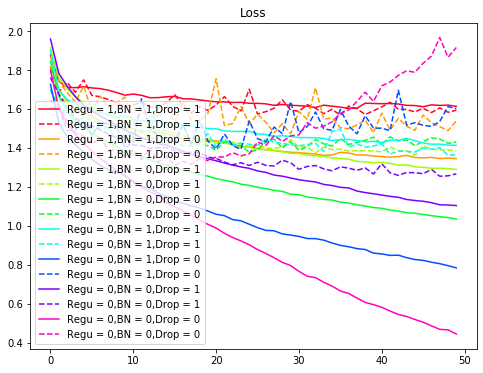

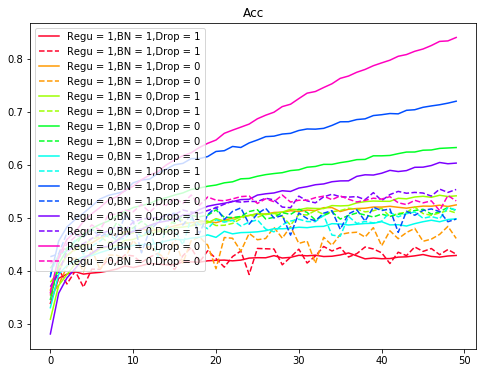

'Code Here\n將結果繪出\n'

In [41]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
Num_colors = len(list(itertools.product(Regus, BNs, Drops)))
cm = plt.get_cmap('gist_rainbow')
cNorm = colors.Normalize(vmin=0, vmax=Num_colors-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar=[scalarMap.to_rgba(i) for i in range(Num_colors)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'],'-',label=cond,color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'],'--',label=cond,color=color_bar[i])
plt.title('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'],'-',label=cond,color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'],'--',label=cond,color=color_bar[i])
plt.title('Acc')
plt.legend()
plt.show()
"""Code Here
將結果繪出
"""
